# Analyzing an inspiral-merger-ringdown injection

In this example, we analyze the ringdown of a simulated quasicircular binary-black-hole coalescence (an _injection_ in LIGO lingo), adding synthetic noise to the data. In the parlance of ringdown analyses, we will refer to this as an inspiral-merger-ringdown (IMR) injection, as opposed to a ringdown-only injection (cf. _simple damped sinusoid_ example notebook).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# disable numpy multithreading to avoid conflicts
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

## Preamble

In this notebook, we will need some data products produced by the LIGO-Virgo-KAGRA collaborations and the GW community more broadly:
1. a reference PSDs for computed from LIGO-Virgo data around GW150914 [[LIGO-P1900011](https://dcc.ligo.org/cgi-bin/DocDB/ShowDocument?.submit=Identifier&docid=P1900011&version=)];
2. a data file required by the numerical relativity (NR) surrogate waveform `NRSur7dq4` from [Varma et al (2019)](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033015) in a format compatible with the _LALSuite_ code [[doi:10.5281/zenodo.14999310](https://doi.org/10.5281/zenodo.14999310)]
3. [optional] a data file required by the corresponding NR _remnant_ surrogate `NRSur7dq4Remnant` from Varma et al [[doi:10.5281/zenodo.14999310](https://doi.org/10.5281/zenodo.14999310)].

We will use these data products to respectively simulate the instrumental noise and the signal in our data, as well as to compute the remnant black hole (BH) parameters corresponding to the initial binary parameters for the signal we are simulating (this is only used to compare to the mass and spin inferred by the ringdown analysis).

_NOTE: if you have an existing installation of the [LALSuite Waveform data](https://git.ligo.org/waveforms/software/lalsuite-waveform-data) (formerly `lalsuite-extra`), you do not need to download the NRSur7dq4 file; simply point `LAL_DATA_PATH` to the corresponding directory below._

In [ ]:
!wget -nc https://dcc.ligo.org/public/0158/P1900011/001/GWTC1_GW150914_PSDs.dat
!wget -nc https://zenodo.org/records/14999310/files/NRSur7dq4_v1.0.h5
!wget -nc https://zenodo.org/records/14999310/files/NRSur7dq4Remnant_v1.0.h5

The PSD-file we have just downloaded contains three columns of numbers corresponding to frequencies, Hanford (H1) PSD values and Livingston (L1) PSD values. To use this below, we will need to load these data into individual `PowerSpectrum` objects that the _ringdown_ package can recognize.

In [5]:
psds_o1 = np.loadtxt('GWTC1_GW150914_PSDs.dat')

psds_o1 ={
    'H1': rd.PowerSpectrum(psds_o1[:,1], index=psds_o1[:,0], ifo='H1').fill_low_frequencies(),
    'L1': rd.PowerSpectrum(psds_o1[:,2], index=psds_o1[:,0], ifo='L1').fill_low_frequencies()
}

The `PowerSpectrum` class is a wrapper around a _pandas_ `Series` with some nifty added features tailored for PSD frequency-series. Above, we are using the `fill_low_frequencies` method to extend the PSD all the way down to zero frequency, even though the files started at 20 Hz.

In [6]:
psds_o1['H1']

0.000       2.399920e-39
0.125       2.399920e-39
0.250       2.399920e-39
0.375       2.399920e-39
0.500       2.399920e-39
                ...     
1023.500    3.704350e-47
1023.625    3.814600e-47
1023.750    3.921475e-47
1023.875    4.027316e-47
1024.000    4.027316e-47
Name: H1, Length: 8193, dtype: float64

## Fake noise

We will use the PSDs we downloaded above to simulate some GW15014-like data. We can do that easily with a `Fit` object from the _ringdown_ package. First, initialize an empty fit.

In [7]:
fit = rd.Fit()

Now we want to draw some data from the PSDs we loaded above. It's easy to do this using `Fit.fake_data`, we just need to define an epoch to index sample times with GPS times; the specific value we choose is taken from GW150914, but you can make this be whatever you want. We can also specify the duration of data we want to simulate (defaults is derived from PSD sampling rate).

In [8]:
# define center of time array t0 (we will also use this as an injection time below)
# alternatively, we could provide `epoch`, taken to be the beginning of the time array
# rather than its center
tgps_geo = 1126259462.423

# we will fix the random seed (PRNG) to make the notebook reproducible
fit.fake_data(psds=psds_o1, duration=4, t0=tgps_geo, record_acfs=True, prng=1234)

We can compare a Welch estimate of the data we just generated with the PSD we used to generate it; they should roughly match up to sampling error and differences in frequency spacing.

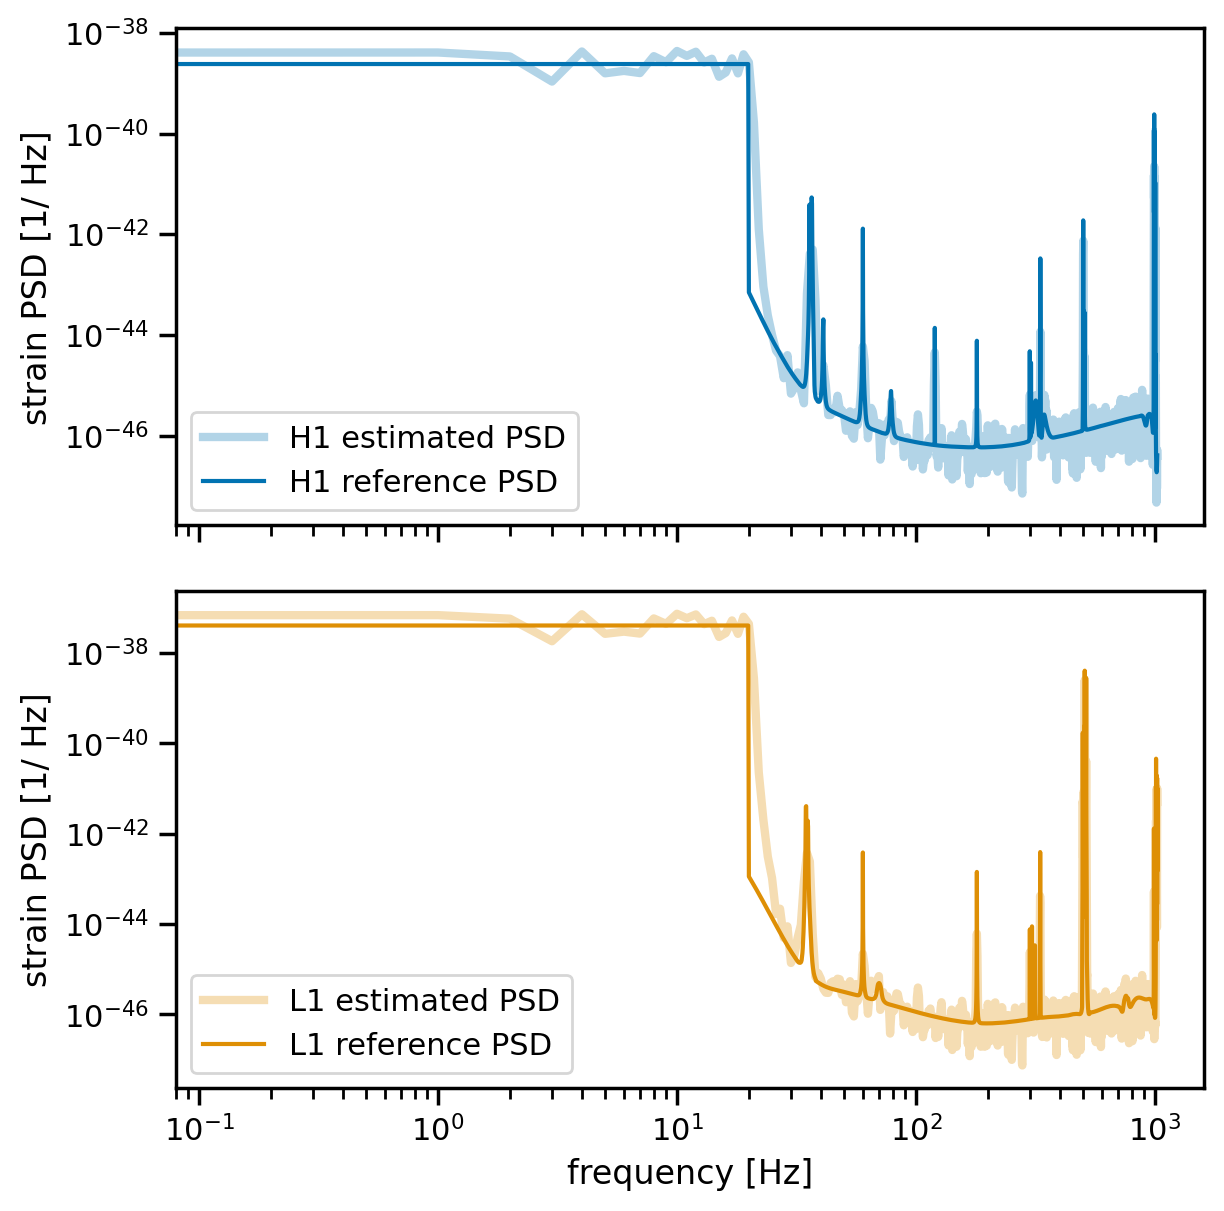

In [9]:
fig, axs = plt.subplots(len(fit.ifos), 1, figsize=(6, 6), sharex=True)
plt.tight_layout()
axs = np.atleast_1d(axs)
for i, (ifo, data) in enumerate(fit.data.items()):
    ax = axs[i]
    psd_estimate = data.get_psd()
    psd_ligo = psds_o1[ifo]
    ax.loglog(psd_estimate, label=f'{ifo} estimated PSD', lw=3, alpha=0.3, c=f'C{i}')
    ax.loglog(psd_ligo, label=f'{ifo} reference PSD', c=f'C{i}')
    ax.set_ylabel('strain PSD [1/ Hz]');
    ax.legend(loc='lower left')
axs[-1].set_xlabel('frequency [Hz]');

Note that we ran `fake_data` with the `record_acfs = True` option; as a result, the PSDs were internally IFFT'd to obtain a time-domain autocovariance function (ACF) via `PowerSpectrum.to_acf()`, which we can plot:

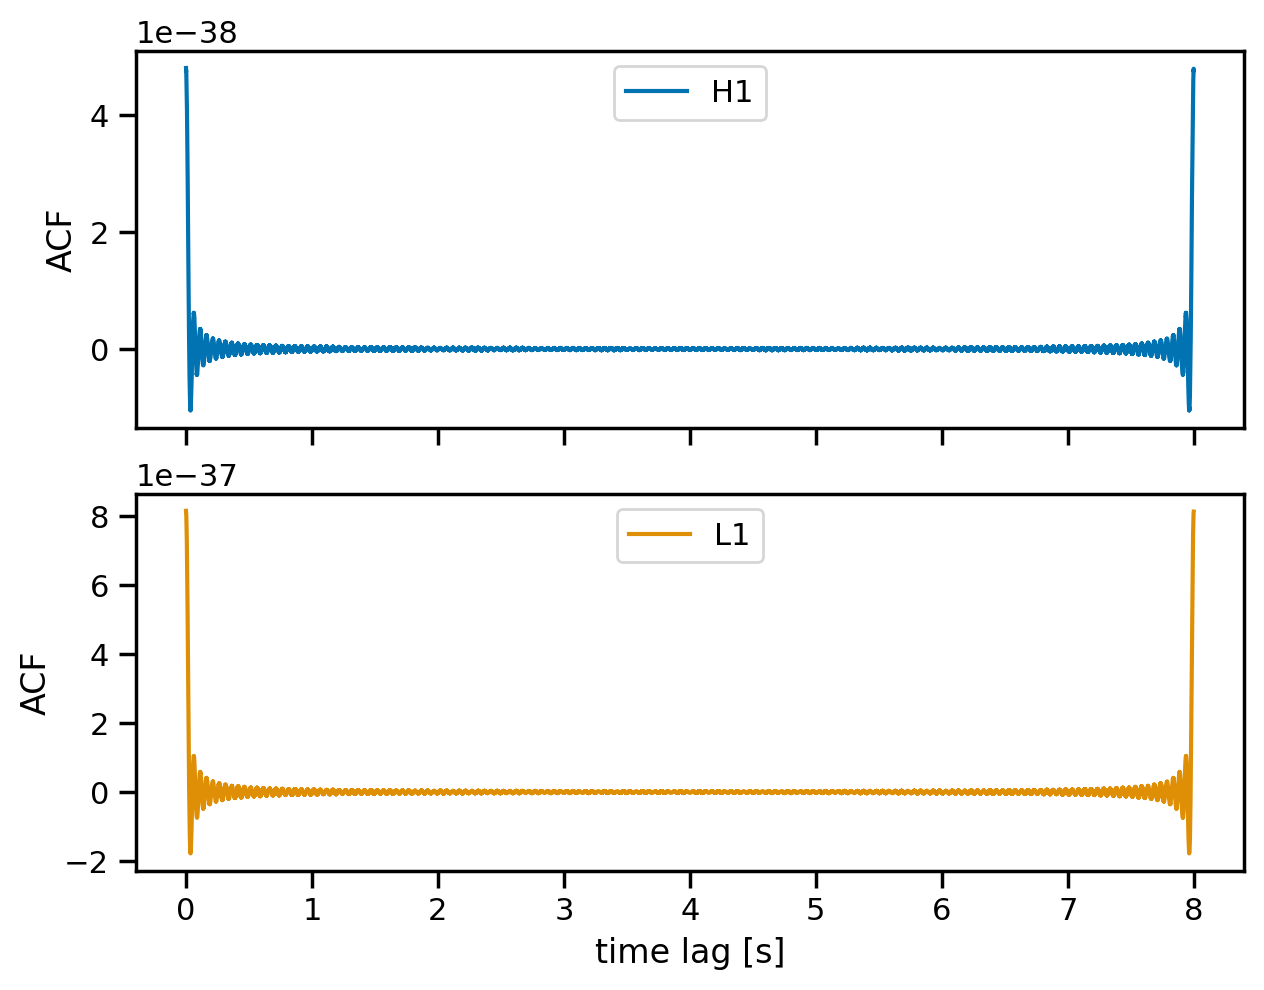

In [10]:
fig, axs = plt.subplots(len(fit.ifos), 1, sharex=True)
plt.tight_layout()
axs = np.atleast_1d(axs)
for i, (ifo, acf) in enumerate(fit.acfs.items()):
    axs[i].plot(acf, label=ifo, c=f'C{i}')
    axs[i].set_ylabel('ACF')
    axs[i].legend(loc='upper center')
axs[-1].set_xlabel('time lag [s]');

These ACFs have a cyclic structure because they were derived by IFFT'ing a PSD---that would be bad if we were analyzing an 8 s of data (the span of this ACF, as implied by the frequency spacing PSD) because it would impose periodic boundary conditions on the analysis segment, which would corrupt our ringdown analysis; however, the ringdown analysis segment will be two orders of magnitude shorter than this.

<div class="alert alert-info">

Tip

We recommend that the PSD segment-length ($T = 1/\Delta f$) be no shorter than 10x the ringdown analysis duration.

</div>

## Fake signal

Now that we have some fake data in our fit, we can inject a fake signal. We will use the `NRSur7dq4` model to simulate an inspiral-merger-ringdown (IMR) signal similar to GW150914 and project into onto the LIGO network.

To do this we will use `Fit.inject()`, which allows us to interact with LALSimulation in a straightforward way.

In [11]:
# tell LALSimulation where to find the NRSur7dq4 data file
os.environ["LAL_DATA_PATH"] = os.getcwd()


wf_kws = dict(
    model='NRSur7dq4',  # waveform approximant
    mtot = 72,  # total mass in solar masses
    q=1,  # mass ratio m2/m1 < 1 
    ra = 1.95,  # right ascension
    dec = -1.26,  # declination
    psi = 0.82,  # polarization
    inclination = np.pi,  # inclination
    dist = 440,  # luminosity distance in Mpc
    phi_ref = 2.41,  # reference phase
    geocent_time = tgps_geo,  # peak time
    f_low = 15,  # initial frequency
)

fit.inject(manual_epoch=True, window=True, **wf_kws)

<div class="alert alert-info">

Note

These parameters are loosely based on GW150914 for illustration but do not correspond to any sort of "best fit".

</div>

Simulated signals corresponding to these parameters have been added to each of the detectors for which we have data. We can access the templates by looking in `fit.injections` and you can check that `fit.has_injections` is `True` and check the injection parameters:

In [12]:
fit.injection_parameters

Parameters(mass_1=36.0, mass_2=36.0, spin_1x=0.0, spin_1y=0.0, spin_1z=0.0, spin_2x=0.0, spin_2y=0.0, spin_2z=0.0, luminosity_distance=440.0, iota=3.141592653589793, phase=0.0, long_asc_nodes=0.0, eccentricity=0.0, mean_per_ano=0.0, f_low=15.0, f_ref=15.0, psi=0.82, ra=1.95, dec=-1.26, trigger_time=1126259462.423)

We can also derive the corresponding remnant parameters; by default, this uses the `NRSur7dq4Remnant` model:

In [13]:
fit.injection_parameters.final_mass, fit.injection_parameters.final_spin

(array([68.51374495]), 0.6865003753640136)

 Let's plot the signals we just simulated, and zoom around the merger.

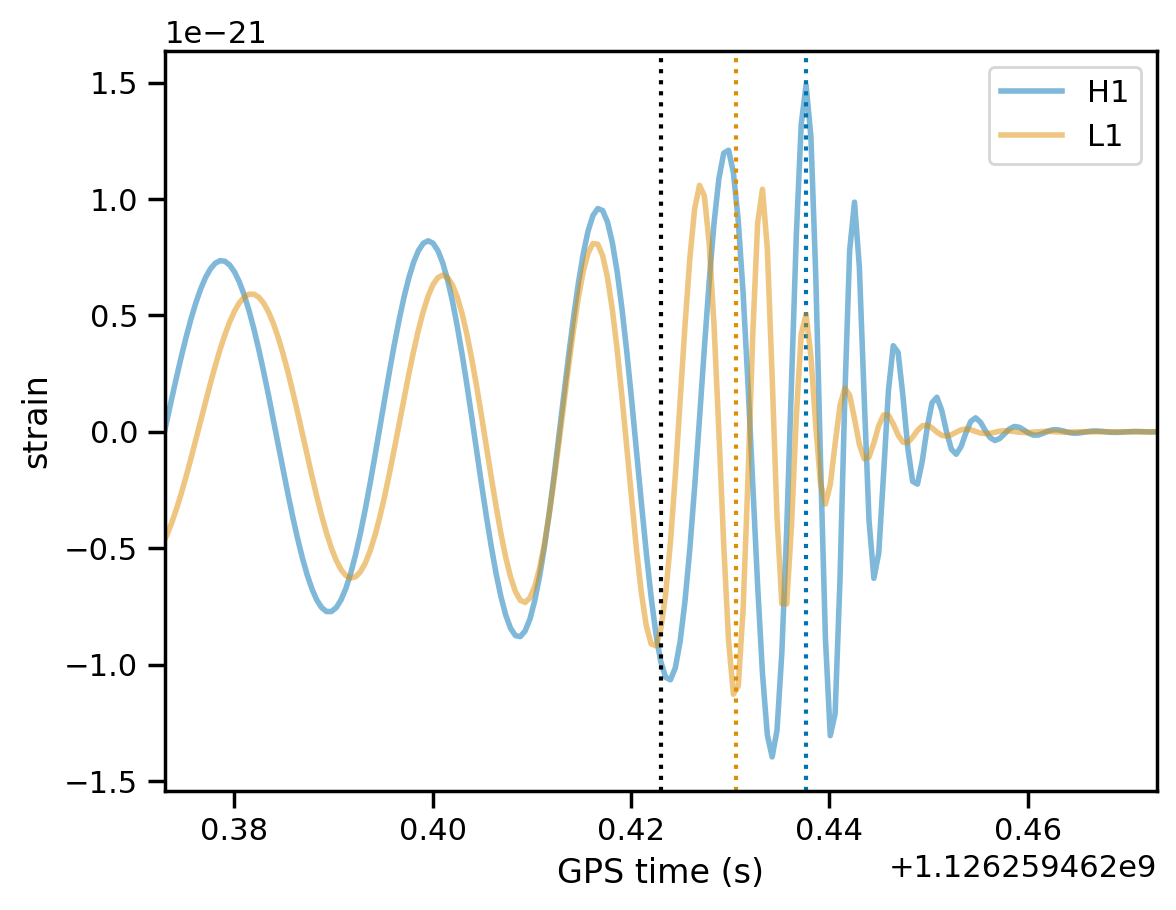

In [14]:
fig, ax = plt.subplots(1, 1)
for ifo, h in fit.injections.items():
    l, = ax.plot(h, alpha=0.5, lw=2, label=ifo)
    ax.axvline(h.attrs['t0']+h.attrs['delay'], ls=':', c=l.get_color())

ax.axvline(tgps_geo, ls=':', c='k')

ax.set_xlabel("GPS time (s)")
ax.set_ylabel("strain")
ax.legend();

# zoom in
ax.set_xlim(tgps_geo - 0.05, tgps_geo + 0.05);

The vertical dotted lines show the arrival time of the peak of the strain envelope ($\sqrt{h_+^2 + h_\times^2}$) at geocenter (black) and each detector (color). By indicating `manual_epoch=True` we ensured the trigger time is interpreted as the time of this peak, so that the geocenter time is the same we had indicated above.

We can now compare this signal to the PSDs of our simulated data and compute and injected (optimal) SNR. We will plot the _characteristic strain_ as defined in [Moore et al (2015)](https://iopscience.iop.org/article/10.1088/0264-9381/32/1/015014).

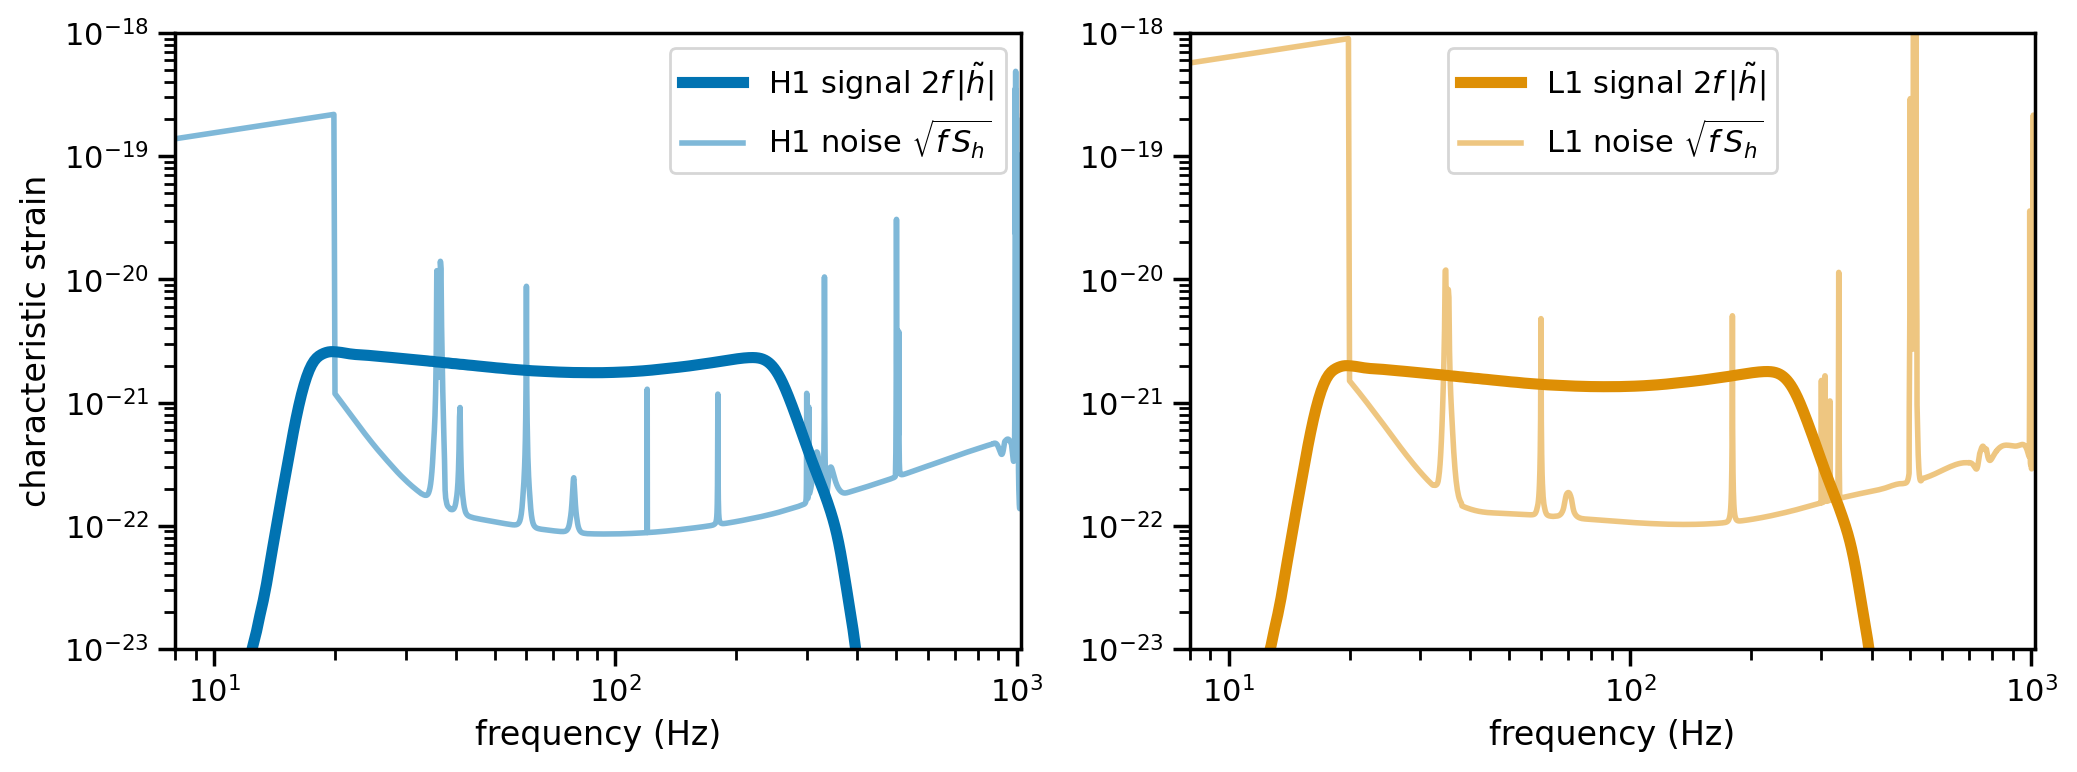

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = np.atleast_1d(axs)

snrs = {}
for i, (ifo, h) in enumerate(fit.injections.items()):
    ax = axs[i]
    
    # plot Fourier transform injected waveform
    h_fd = h.to_frequency_series()
    l, = ax.loglog(h_fd.freq, 2*abs(h_fd)*h_fd.freq, label=ifo+r' signal $2 f\, |\tilde{h}|$', lw=4, c=f'C{i}')

    # plot characteristic strain corresponding to PSD
    psd = psds_o1[ifo]    
    ax.loglog(psd.freq, np.sqrt(psd*psd.freq), c=f'C{i}', lw=2, alpha=0.5, label=ifo+r' noise $\sqrt{f\, S_h}$', )

    # compute optimal SNR at detector
    snrs[ifo] = psd.compute_snr(h_fd, f_min=20)

    ax.set_ylim(1E-23, 1E-18)
    ax.set_xlim(8, 1024)
    ax.legend()
    ax.set_xlabel("frequency (Hz)")
axs[0].set_ylabel("characteristic strain")

# compute network SNR
snrs['net'] = np.linalg.norm(list(snrs.values()))

The optimal SNR for the injected IMR signal is:

In [16]:
snrs

{'H1': 26.883006621861693, 'L1': 18.264832260762535, 'net': 32.50077141461186}

Finally, note that _ringdown_ allows us to easily obtain the remnant mass and spin corresponding to the injection parameters. This step uses the `NRSur7dq4Remnant` file we downloaded above.

In [17]:
remnant_mass = fit.injection_parameters.final_mass
remnant_spin = fit.injection_parameters.final_spin

<div class="alert alert-info">

Tip

The `Fit.inject()` method makes use of the _ringdown_ waveform interface, which can seamlessly handle IMR and damped-sinusoid injections. See the docs for `ringdown.Signal` to learn more.

</div>

## Fit

We are now finally ready to carry out a ringdown fit! We will set the modes for the fit and the target time (see other examples for discussion of these).

In [18]:
# fit a fundamental mode and an overtone (220+221)
fit.set_modes([(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])

Specify a target based on the values we used for the injection, and setting an analysis duration in seconds:

In [19]:
# collect sky location arguments
skyloc = {k: fit.injection_parameters[k] for k in ['ra', 'dec', 'psi']}

fit.set_target(fit.injection_parameters.trigger_time, duration=0.05, **skyloc)

In [20]:
fit.target, fit.duration

(SkyTarget(geocenter_time=LIGOTimeGPS(1126259462, 423000097), ra=1.95, dec=-1.26, psi=0.82, duration=0.05),
 0.05)

Now we only need to update the prior and we can run it!

In [21]:
fit.update_model(a_scale_max=10e-21, m_min=35.0, m_max=140.0, cosi=-1)

In [22]:
fit.run(prng=150914)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

`fit.result` contains an arviz object giving our results.

## Result

We can plot a trace, and see visually that the sampling seems OK and no chains got stuck (by default _ringdown_ runs 4 chains).

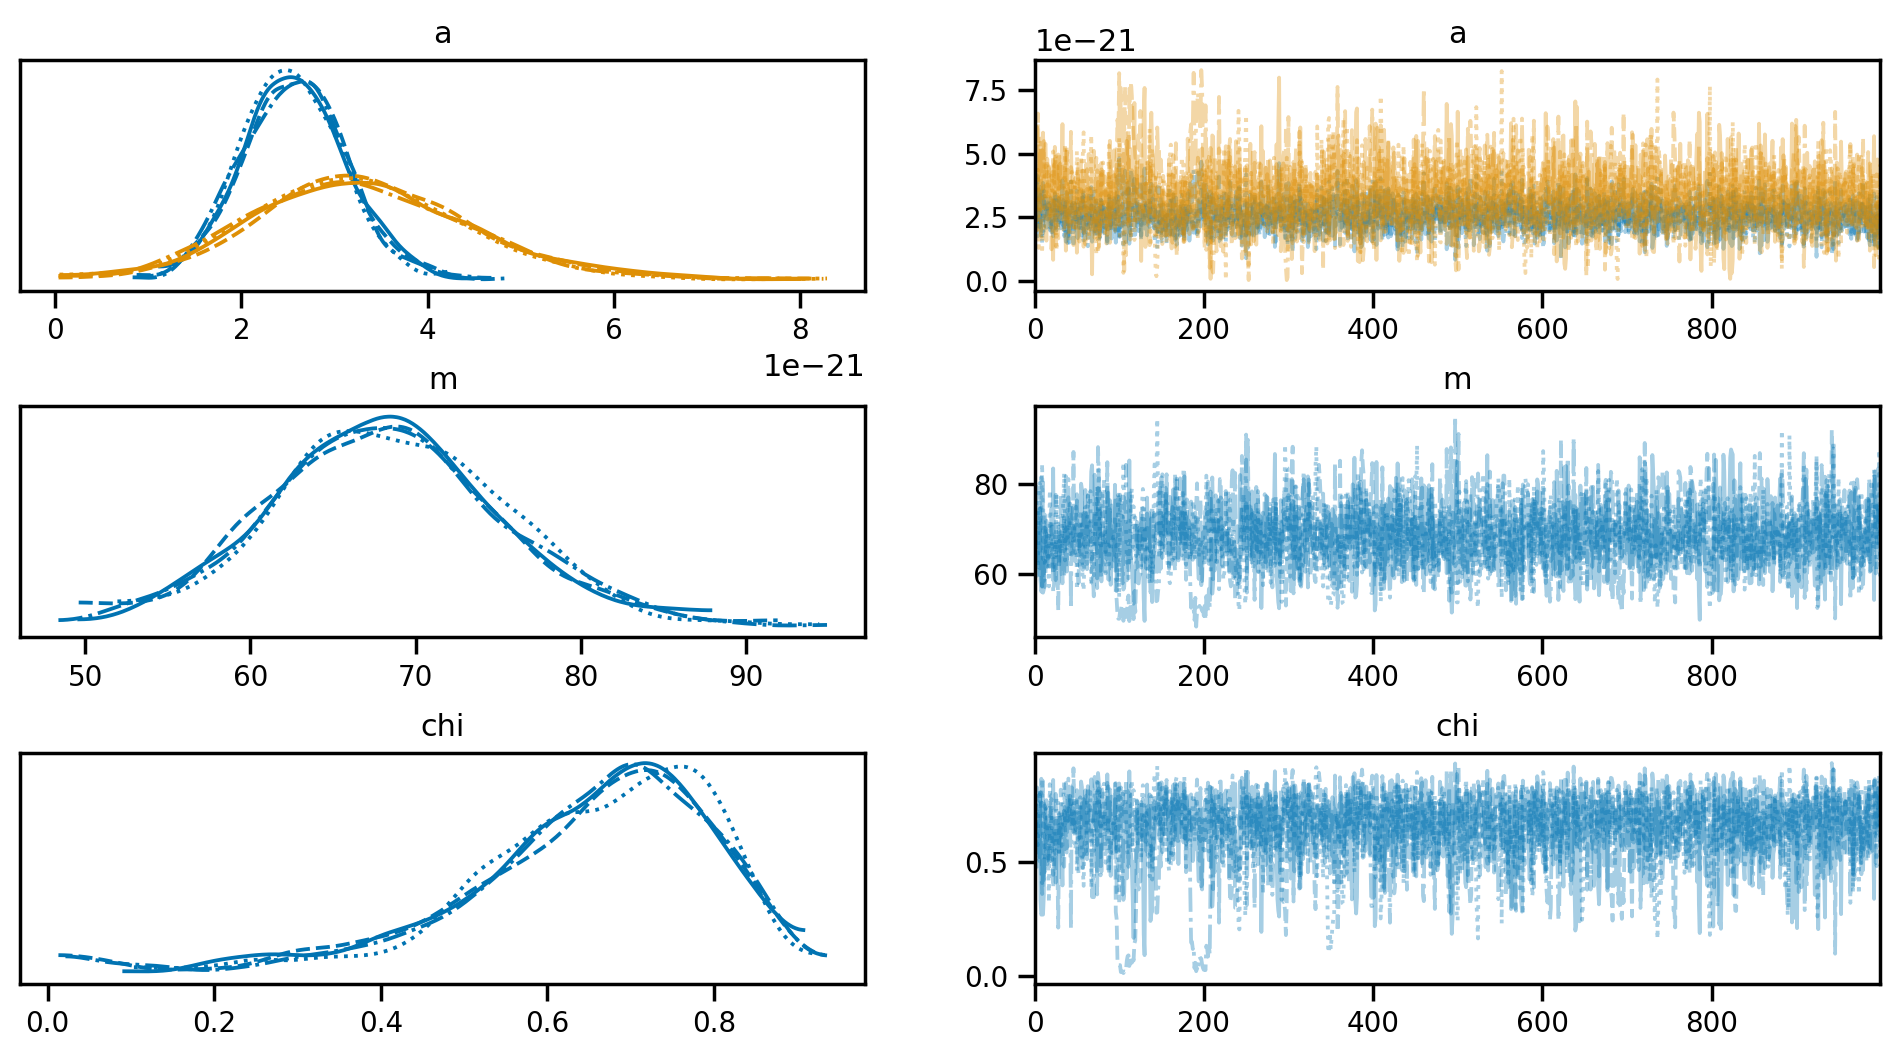

In [23]:
az.plot_trace(fit.result, var_names=['a', 'm', 'chi'], compact=True);
plt.subplots_adjust(hspace=0.5)

We can plot a corner plot of the recovered remnant parameters and compared them to those we expect from the injection.

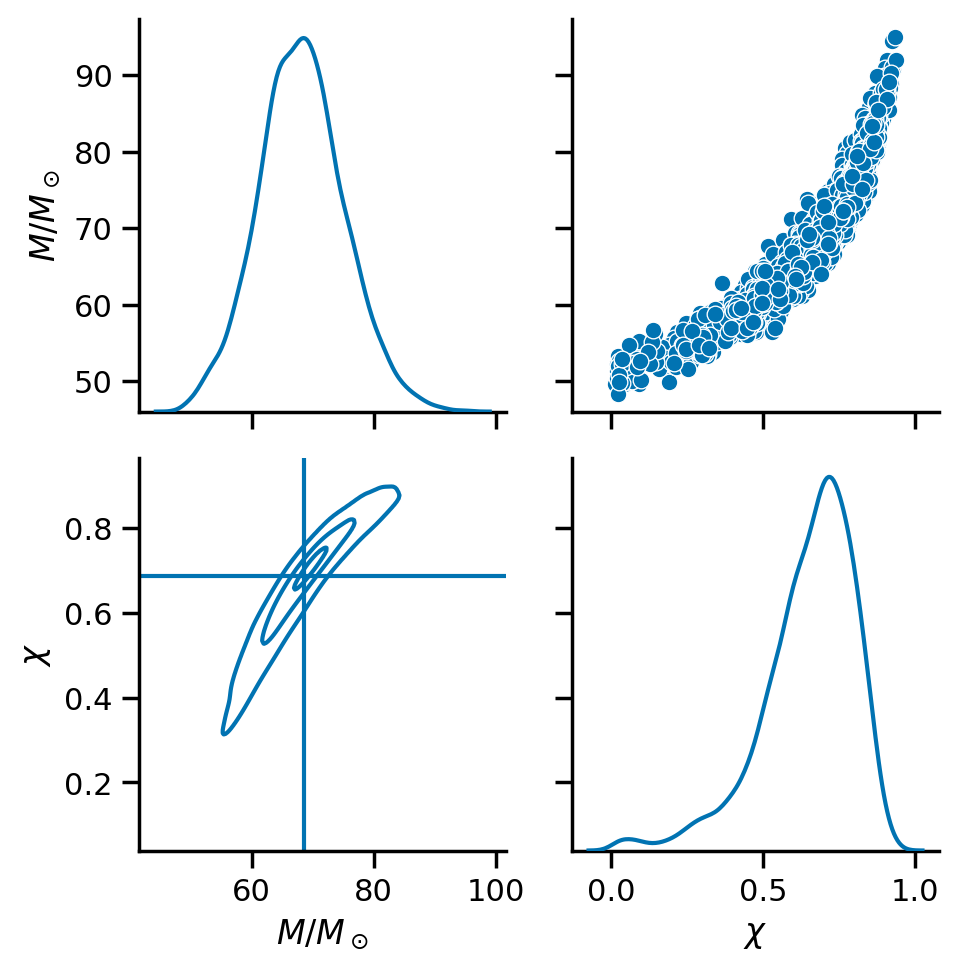

In [24]:
df = pd.DataFrame({
    r'$M / M_\odot$': fit.result.posterior.m.values.flatten(),
    r'$\chi$': fit.result.posterior.chi.values.flatten()
})
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(rd.utils.kde_contour.kdeplot_2d_clevels, levels=[0.9, 0.5, 0.1]);

# plot true values
pg.axes[1,0].axvline(remnant_mass)
pg.axes[1,0].axhline(remnant_spin);

We can also plot the 90%-credible recovered waveforms at each detector and compare them to the true signal we simulated:

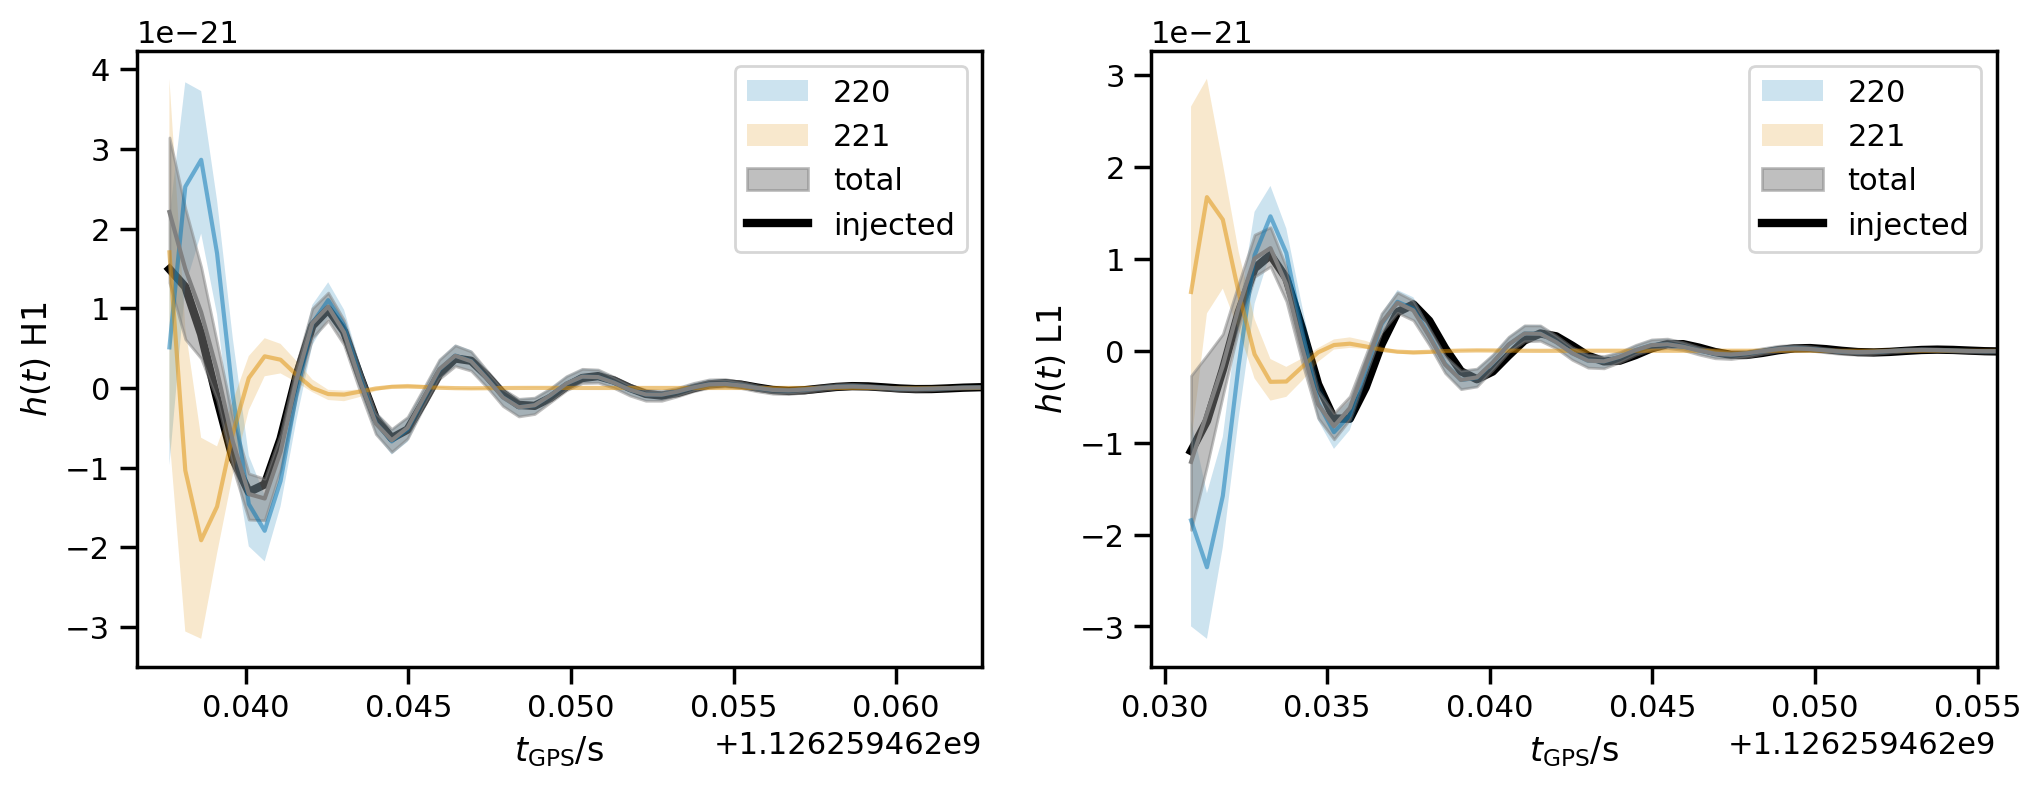

In [ ]:
fig, axs = plt.subplots(1, len(fit.ifos), figsize=(12, 4))
axs = np.atleast_1d(axs)
for mode in fit.result.modes:
    hdet_mode_cls = [fit.result.get_strain_quantile(q, mode=mode) for q in [0.5, 0.05, 0.95]]
    for i, ax in zip(fit.ifos, axs):
        m, l, h = [hcl[i] for hcl in hdet_mode_cls]
        ax.plot(m, alpha=0.5)
        ax.fill_between(m.index, l, h, label=mode.get_label(), alpha=0.2)

hdet_cls = [fit.result.get_strain_quantile(q) for q in [0.5, 0.05, 0.95]]
for i, ax in zip(fit.ifos, axs):
    m, l, h = [hcl[i] for hcl in hdet_cls]

    ax.plot(m, color='gray')
    ax.fill_between(m.index, l, h, label='total', alpha=0.5, color='gray')

    ax.plot(fit.analysis_injections[i], c='k', lw=3, label='injected', zorder=-100)

    ax.set_xlim(fit.start_times[i] - 0.001, fit.start_times[i] + 0.025)
    ax.set_xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$')
    ax.set_ylabel(f'$h(t)$ {i}');
    ax.legend();

#### Signal-to-noise ratio time series

The `fit.result` object contains a handy method to automatically compute the cumulative SNR timeseries, whether for the optimal SNR or the matched filter SNR, and for both the whole network or individual detectors. This is computed for each sample in the posterior. 

In [26]:
snr_times_ifo = fit.result.compute_posterior_snrs(optimal=True, network=False, cumulative=True)

We can now plot the median over the posterior samples, as well as the symmetric 90\%-credible band around it.

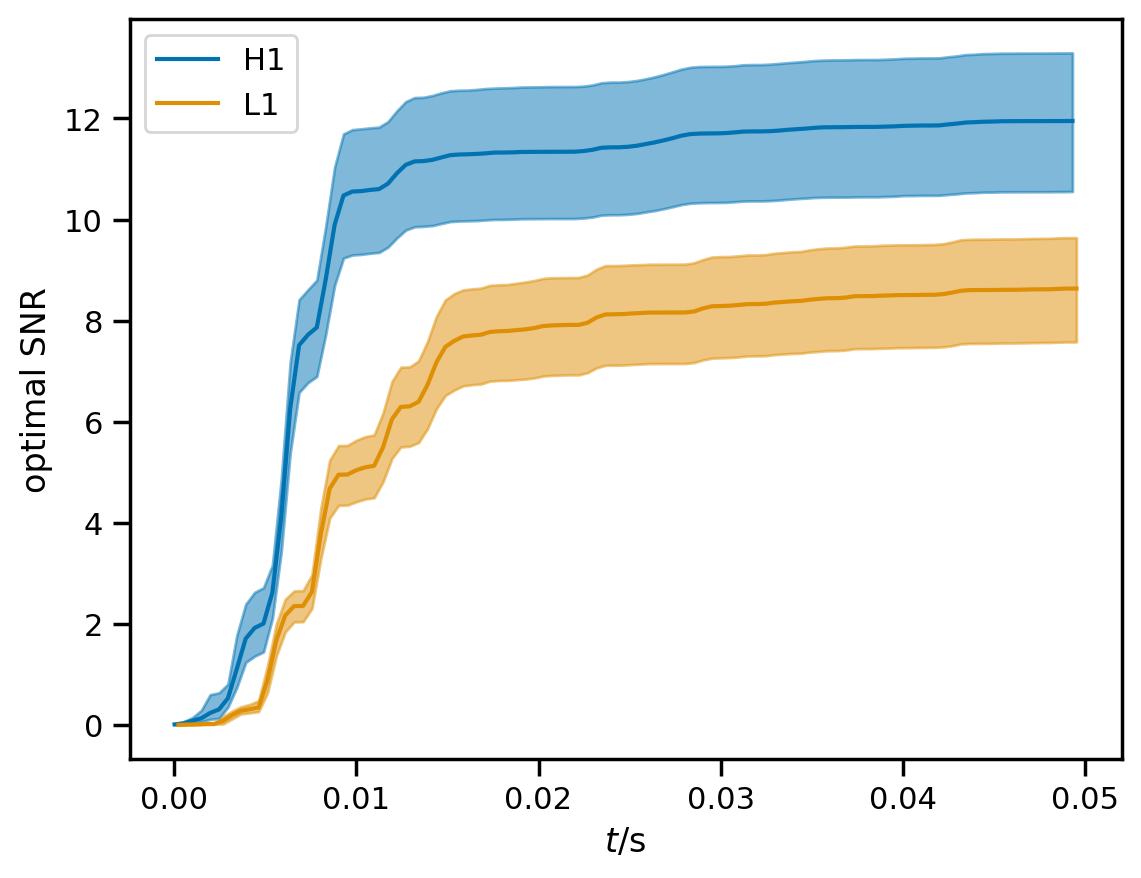

In [27]:
l, m, h = np.quantile(snr_times_ifo, [0.05, 0.5, 0.95], axis=2)

for i, ifo in enumerate(fit.ifos):
    t = fit.analysis_times[ifo] - fit.start_times[ifo]
    plt.fill_between(t, l[i], h[i], alpha=0.5, color=f'C{i}')
    plt.plot(t, m[i], label=ifo, c=f'C{i}')

plt.legend(loc='best');
plt.xlabel(r'$t / \mathrm{s}$');
plt.ylabel('optimal SNR');

We can also get the total ringdown matched-filter SNR recovered over the network:

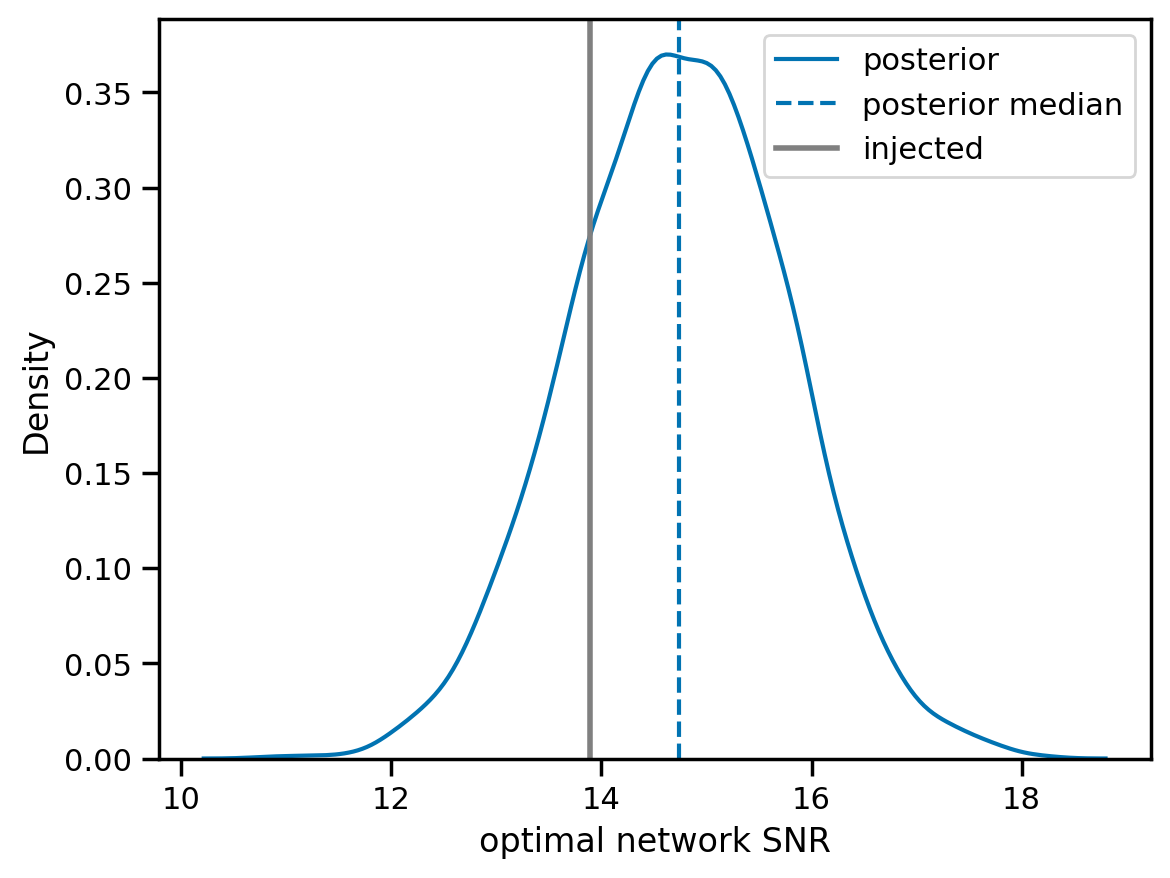

In [28]:
injected_snr = fit.compute_injected_snrs(network=True)
snrs = fit.result.compute_posterior_snrs(optimal=True, network=True)

sns.kdeplot(snrs, label='posterior');
plt.axvline(np.median(snrs), ls='--', label='posterior median')
plt.axvline(injected_snr, lw=2, c='gray', label='injected')
plt.legend()
plt.xlabel('optimal network SNR');